# Whisper openai/whisper-large-v3 Documentation
---

# Introduction

In the process of fine-tuning the Whisper model in Python, we will leverage several prominent packages to optimize performance and facilitate seamless integration. Our workflow entails utilizing $datasets$ for data management and preparation, alongside $transformers$ and $accelerate$ for model loading and training. The integration of the $soundfile$ package is crucial for audio file preprocessing, ensuring compatibility and efficiency throughout the process. To evaluate the efficiency of our model, we will employ $jiwer$ for performance assessment, enabling comprehensive analysis of transcription accuracy.

Furthermore, $tensorboard$ will be instrumental in logging metrics, offering a structured approach to monitor and track the model's progression during training phases. Its visualization capabilities provide valuable insights into the model's behavior and performance trends. Lastly, $gradio$ will be utilized to construct an interactive and visually appealing demo of our fine-tuned model, enhancing user experience and accessibility.

By incorporating these Python packages into our workflow, we aim to streamline the fine-tuning process, optimize model performance, and deliver a polished demonstration of our Whisper model's capabilities. This comprehensive approach underscores our commitment to leveraging cutting-edge tools and techniques to achieve optimal results in the field of audio processing and natural language understanding.

## Model Description
- Open AI `whisper-large-v3`
- Dataset `mozilla-foundation/common_voice_11_0`

# Hardware Requirements
- NVIDIA A100 Tensor Core GPU/ NVIDIA H100/NVIDIA A40

To check GPU `nvidia-smi` command.

In [4]:
!pip install --upgrade pip
!pip install --upgrade datasets transformers accelerate soundfile librosa evaluate jiwer tensorboard gradio

# Imports

In [10]:
import torch
import evaluate

from datasets import Audio
from transformers import WhisperFeatureExtractor
from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from transformers import WhisperProcessor

from dataclasses import dataclass
from datasets import load_dataset, DatasetDict
from typing import Any, Dict, List, Union
from huggingface_hub import notebook_login

# Login 
Linking the notebook to the Hub is straightforward - it simply requires entering your Hub authentication token when prompted.
##### [Authentication Token](https://huggingface.co/settings/tokens)

In [7]:
notebook_login()

# Dataset

Common Voice is a series of crowd-sourced datasets where speakers record text from Wikipedia in various languages. We'll use the latest edition of the Common Voice dataset (version 11). As for our language, we'll fine-tune our model on Hindi, an Indo-Aryan language spoken in northern, central, eastern, and western India. Common Voice 11.0 contains approximately 12 hours of labelled Hindi data, 4 of which are held-out test data.

Let's head to the Hub and view the dataset page for Common Voice: [Dataset Link](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0) (mozilla-foundation/common_voice_11_0)

**`Ensure that the dataset is clean and does not contain any null values.`**

In [ ]:
ds = load_dataset("mozilla-foundation/common_voice_11_0",split="train")

## Splitting the dataset

In [ ]:
common = ds.train_test_split(test_size=0.25)
common

- Line selects the first 500 rows from the "train" dataset. The range(500) function generates a sequence of numbers from 0 to 499, which corresponds to the indices of the rows to be selected.

- Similarly, select the first 50 rows from the "test" dataset.

In [ ]:
common["train"] = common["train"].select(range(500)) 
common["test"] = common["test"].select(range(50)) 

### Feature Extractor
- Speech is represented by a 1-dimensional array that varies with time. The value of the array at any given time step is the signal's amplitude at that point. From the amplitude information alone, we can reconstruct the frequency spectrum of the audio and recover all acoustic features.

- Since speech is continuous, it contains an infinite number of amplitude values. This poses problems for computer devices which expect finite arrays. Thus, we discretise our speech signal by sampling values from our signal at fixed time steps. The interval with which we sample our audio is known as the sampling rate and is usually measured in samples/sec or Hertz (Hz). Sampling with a higher sampling rate results in a better approximation of the continuous speech signal, but also requires storing more values per second.

- It is crucial that we match the sampling rate of our audio inputs to the sampling rate expected by our model, as audio signals with different sampling rates have very different distributions. Audio samples should only ever be processed with the correct sampling rate. Failing to do so can lead to unexpected results! For instance, taking an audio sample with a sampling rate of 16kHz and listening to it with a sampling rate of 8kHz will make the audio sound as though it's in half-speed. In the same way, passing audio with the wrong sampling rate can falter an ASR model that expects one sampling rate and receives another. The Whisper feature extractor expects audio inputs with a sampling rate of 16kHz, so we need to match our inputs to this value. We don't want to inadvertently train an ASR system on slow-motion speech!

- The Whisper feature extractor performs two operations. It first pads/truncates a batch of audio samples such that all samples have an input length of 30s. Samples shorter than 30s are padded to 30s by appending zeros to the end of the sequence (zeros in an audio signal corresponding to no signal or silence). Samples longer than 30s are truncated to 30s. Since all elements in the batch are padded/truncated to a maximum length in the input space, we don't require an attention mask when forwarding the audio inputs to the Whisper model. Whisper is unique in this regard - with most audio models, you can expect to provide an attention mask that details where sequences have been padded, and thus where they should be ignored in the self-attention mechanism. Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs.

- The second operation that the Whisper feature extractor performs is converting the padded audio arrays to log-Mel spectrograms. These spectrograms are a visual representation of the frequencies of a signal, rather like a Fourier transform.

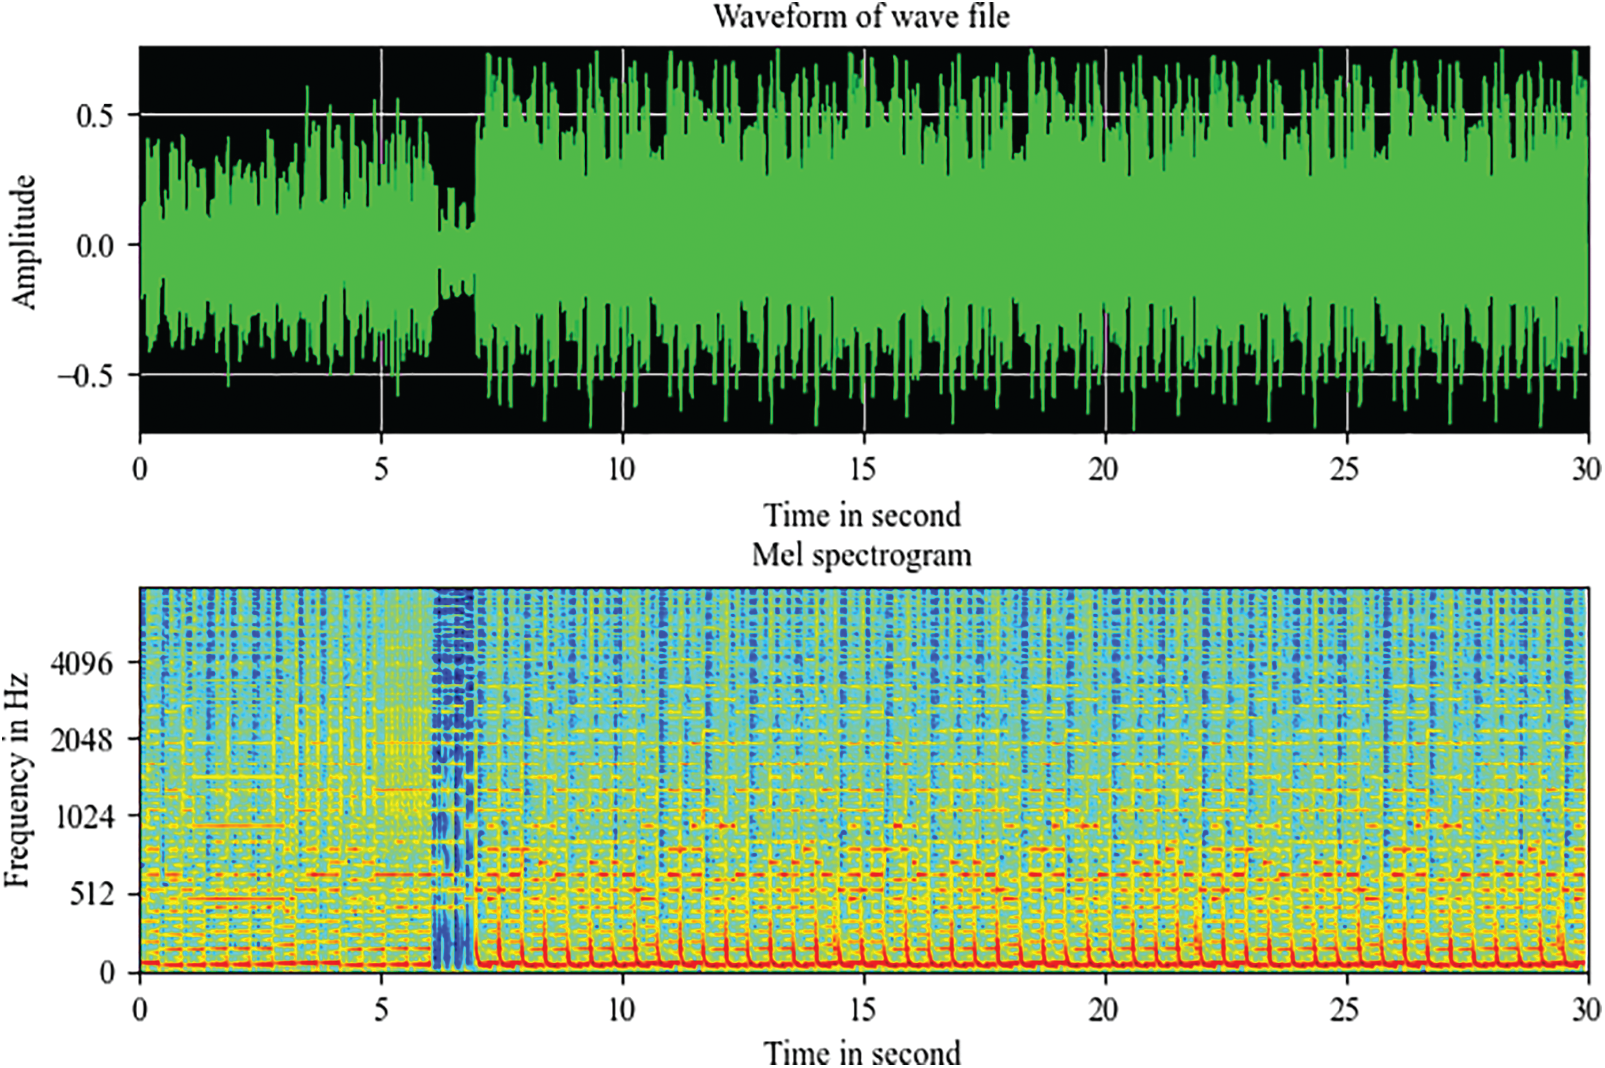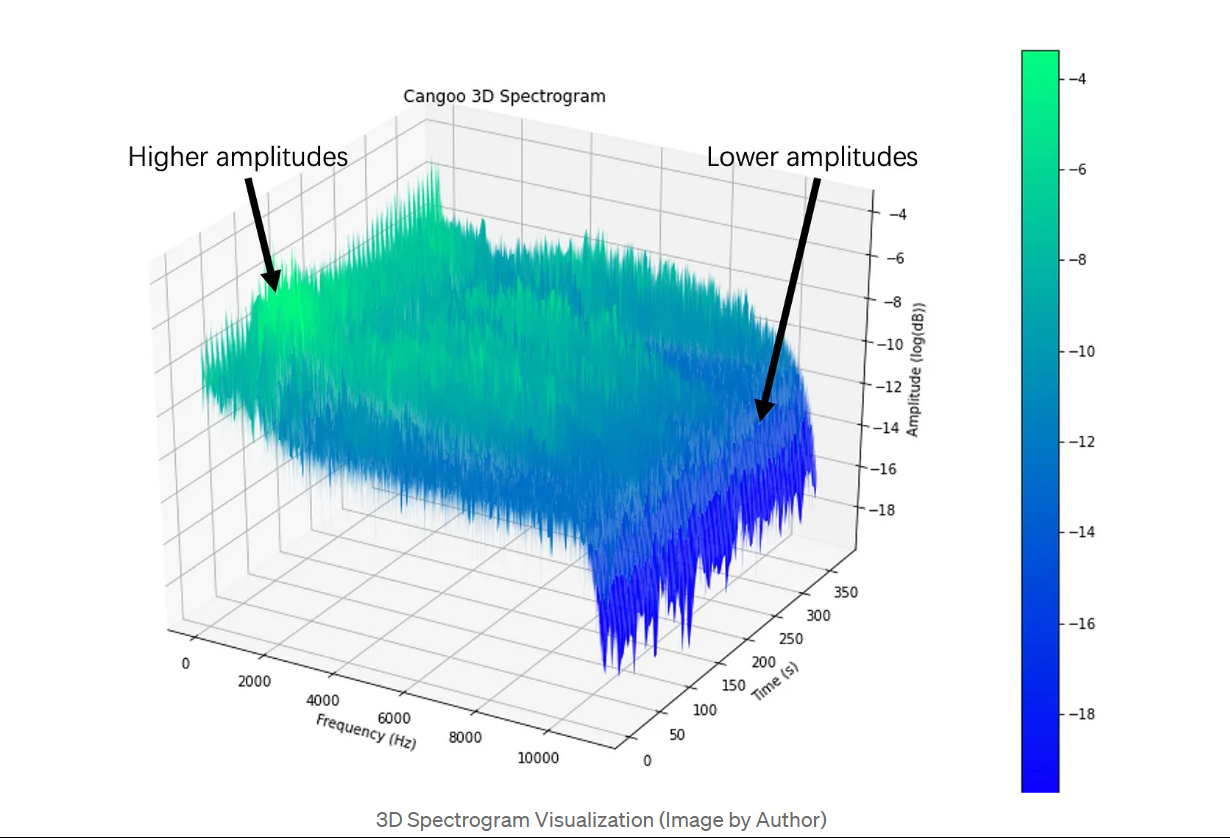

In [19]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-large-v3")

- The Whisper tokenizer is pre-trained on the transcriptions for the 96 pre-training languages. Consequently, it has an extensive byte-pair that is appropriate for almost all multilingual ASR applications. For Hindi, we can load the tokenizer and use it for fine-tuning without any further modifications. We simply have to specify the target language and the task.
- We can verify that the tokenizer correctly encodes Hindi characters by encoding and decoding the first sample of the Common Voice dataset. When encoding the transcriptions, the tokenizer appends 'special tokens' to the start and end of the sequence, including the start/end of transcript tokens, the language token and the task tokens (as specified by the arguments in the previous step). When decoding the label ids, we have the option of 'skipping' these special tokens, allowing us to return a string in the original input form.

In [ ]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-large-v3", task="transcribe")

In [2]:
input_str = common["train"][10]["text"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

# Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it treats the *input_features* and labels independently: the *input_features* must be handled by the feature extractor and the labels by the tokenizer.

The *input_features* are already padded to 30s and converted to a log-Mel spectrogram of fixed dimension, so all we have to do is convert them to batched PyTorch tensors. We do this using the feature extractor's .pad method with *return_tensors=pt*. Note that no additional padding is applied here since the inputs are of fixed dimension, the input_features are simply converted to PyTorch tensorss.

On the other hand, the labels are un-padded. We first pad the sequences to the maximum length in the batch using the tokenizer's .pad method. The padding tokens are then replaced by -100 so that these tokens are not taken into account when computing the loss. We then cut the start of transcript token from the beginning of the label sequence as we append it later during training.

In [ ]:
@dataclass
class Processor:
    feature_extractor: Any
    tokenizer: Any

class DataCollatorSpeechSeq2SeqWithPadding:
    def __init__(self, processor:Processor):
        self.processor = processor
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]
        batch["labels"] = labels
        return batch

my_feature_extractor = feature_extractor
my_tokenizer = tokenizer

# Create an instance of Processor
processor = Processor(feature_extractor=my_feature_extractor, tokenizer = my_tokenizer)

# Create an instance of DataCollatorSpeechSeq2SeqWithPadding
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=Processor)

# Evaluation Matrics
Next, we define the evaluation metric we'll use on our evaluation set. We'll use the Word Error Rate (WER) metric, the 'de-facto' metric for assessing ASR systems. For more information, refer to the WER docs. We'll load the WER metric from Evaluate.

We then simply have to define a function that takes our model predictions and returns the WER metric. This function, called compute_metrics, first replaces -100 with the pad_token_id in the label_ids (undoing the step we applied in the data collator to ignore padded tokens correctly in the loss). It then decodes the predicted and label ids to strings.

In [ ]:
metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

- Now let's load the pre-trained Whisper small checkpoint. Again, this is trivial through use of Transformers!

In [17]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v3")

The Whisper model has token ids that are forced as model outputs before autoregressive generation is started (forced_decoder_ids). These token ids control the transcription language and task for zero-shot ASR. For fine-tuning, we'll set these ids to None, as we'll train the model to predict the correct language (Hindi) and task (transcription). There are also tokens that are completely suppressed during generation (suppress_tokens). These tokens have their log probabilities set to -inf, such that they are never sampled.

In [ ]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

## Define the Training Arguments
In the final step, we define all the parameters related to training. A subset of parameters are explained below:

- output_dir: local directory in which to save the model weights. This will also be the repository name on the Hugging Face Hub.
generation_max_length: maximum number of tokens to autoregressively generate during evaluation.
- save_steps: during training, intermediate checkpoints will be saved and uploaded asynchronously to the Hub every save_steps training steps.
- eval_steps: during training, evaluation of intermediate checkpoints will be performed every eval_steps training steps.
- report_to: where to save training logs. Supported platforms are "azure_ml", "comet_ml", "mlflow", "neptune", "tensorboard" and "wandb". Pick your  favourite or leave as "tensorboard" to log to the Hub.
For more detail on the other training arguments, refer to the Seq2SeqTrainingArguments 
[Docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-v3",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=5,
    max_steps=40,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=50,
    save_steps=10,
    eval_steps=10,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

We can forward the training arguments to the Trainer along with our model, dataset, data collator and *compute_metrics.*

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

# Training 

In [ ]:
trainer.train()

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "whisper-v3",  # a 'pretty' name for your model
    "finetuned_from": "openai/whisper-large-v3",
    "tasks": "automatic-speech-recognition",
    "tags": "hf-asr-leaderboard",
}

- The training results can now be uploaded to the Hub. To do so, execute the *push_to_hub()*

In [ ]:
trainer.push_to_hub(**kwargs)
tokenizer.push_to_hub("whisper-v3") # change the repo name of your choice

You can now share this model with anyone using the link on the Hub. They can also load it with the identifier "your-username/the-name-you-picked" 

In [15]:
model = WhisperForConditionalGeneration.from_pretrained("your_username/whisper-v3")
processor = WhisperProcessor.from_pretrained("your_username/whisper-v3")

- While the fine-tuned model yields satisfactory results on the Common Voice Hindi test data, it is by no means optimal. The purpose of this notebook is to demonstrate how the pre-trained Whisper checkpoints can be fine-tuned on any multilingual ASR dataset. The results could likely be improved by optimising the training hyperparameters, such as learning rate and dropout, and using a larger pre-trained checkpoint (medium or large).

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="your_username/whisper-v3")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["sentence"]
    return text

iface = gr.Interface(
    fn=transcribe, 
    inputs=gr.Audio(source="microphone", type="filepath"), 
    outputs="text",
    title="Whisper Small Hindi",
    description="Realtime demo for Hindi speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()